# Krótkie wprowadzenie do sieci PFN (Prior-data Fitted Networks)

Autor: Bartosz Hanc

Klikając w poniższy link możesz otworzyć ten notebook bezpośrednio w środowisku Google Colab

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/barhanc/nn-core/blob/main/notebooks/tutorials/pfn/pfn-tutorial.ipynb)

## Wykorzystywane biblioteki

Będziemy używać jedynie standardowych bibliotek do uczenia maszynowego: NumPy, PyTorch,
Scikit-learn, Matplotlib i tqdm do logowania postępów uczenia. Jeśli używasz środowiska Google Colab
to wszystkie wymienione biblioteki powinny być domyślnie zainstalowane i dostępne. Jeżeli jednak
korzystasz z własnego komputera to wykonanie poniższej komórki zainstaluje wymagane biblioteki (z
wyjątkiem PyTorcha) za pomocą Pip'a. Instalacja PyTorcha wymaga osobnej instrukcji - szczegółowe
informacje znajdziesz na stronie: [PyTorch - Get Started](https://pytorch.org/get-started/locally/).

Notebook był testowany na Pythonie 3.12.

In [1]:
# %pip install numpy scikit-learn matplotlib tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torch import nn
from torch import Tensor

In [3]:
type DeviceLikeType = str | torch.device

if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device.upper()}")

Using device: CUDA


## Wprowadzenie teoretyczne

Typowe podejście do problemu głębokiego uczenia nadzorowanego polega na ustaleniu pewnej
architektury sieci neuronowej, a następnie uczeniu tej sieci na zbiorze treningowym $D$. W ujęciu
statystycznym rezultatem tego procesu jest aproksymacja warunkowego rozkładu prawdopodobieństwa nad
wartościami zmiennej odpowiedzi $p_\theta(y \mid \mathbf{x})$, opisanego przez wagi $\theta$ sieci,
które zostały wyznaczone poprzez numeryczną maksymalizację wiarygodności danych $D$. Zauważ, że w
tym podejściu sieć neuronowa uczy się przybliżać proces generowania tych konkretnych danych. Jeśli
inductive bias naszej architektury nie jest zgodny z rzeczywistym procesem generacji danych, to taka 
sieć będzie słabo generalizować.

### Prior-data fitting

Ideą sieci PFN jest stworzenie modelu, który wprost przybliża rozkład $q_\theta(y \mid \mathbf{x},
D)$, tj. rozkład zmiennej objaśnianej dla niewidzianych wcześniej wartości predyktorów $\mathbf{x}$
pod warunkiem całego zbioru danych treningowych. Sieć taka nie modeluje więc wprost żadnego
konkretnego procesu generacji danych, lecz potrafi - na podstawie przekazanego na wejściu zbioru
danych treningowych i nowego $\mathbf{x}$ - wyznaczyć rozkład zmiennej objaśnianej dla tego
$\mathbf{x}$. Brzmi to intrygująco, ponieważ taka sieć ma w wagach niejako zaszyty algorytm
wnioskowania (Bayesowskiego, jak zobaczymy później). Zauważ, że dla nowych danych $D$ wykonujemy
tylko jedną propagację przez sieć, aby uzyskać predykcje; nie występuje tu trening na zbiorze $D$
jako taki. 

Od razu jednak nasuwają się pytania:

- dla jakich właściwie zbiorów danych taka sieć będzie wnioskować poprawnie?
- jak ją trenować, aby mogła realizować wspomniany algorytm wnioskowania?
- jak właściwie skonstruować sieć, aby mogła przyjmować cały zbiór danych jako wejście?

Odpowiedzmy najpierw na dwa pierwsze pytania; do trzeciego wrócimy później. Sieć będziemy trenować w
taki sposób, aby modelowany przez nią rozkład $q_\theta(y \mid \mathbf{x}, D)$ przybliżał prawdziwy
rozkład predykcyjny a posteriori (ang. posterior predictive distribution, PPD) $p(y \mid \mathbf{x},
D)$ dla danych $D$ generowanych przez procesy pochodzące z pewnego rozkładu a priori nad procesami
generującymi dane. Innymi słowy, zakładamy pewien rozkład a priori nad procesami generującymi dane
$p(\phi)$ (gdzie $\phi$ oznacza parametry tego procesu) oraz rozkład generujący dane $p(D \mid
\phi)$. Wówczas prawdziwy rozkład PPD jest dany przez

$$
    p(y \mid \mathbf{x}, D) = \int p(y \mid \mathbf{x}, \phi) p(\phi \mid D) \,\mathrm{d}\phi \propto \int p(y \mid \mathbf{x}, \phi) p(D \mid \phi) p(\phi) \,\mathrm{d}\phi
$$

Rozkład ten można wyznaczyć w postaci analitycznej jedynie dla nielicznych prostych modeli (np.
regresji Bayesowskiej czy procesów Gaussowskich). Okazuje się jednak, że do wyznaczenia rozkładu
$q_\theta(y \mid \mathbf{x}, D)$, który będzie przybliżał prawdziwy rozkład PPD, wystarczy jedynie
możliwość próbkowania danych $D$. Istotnie, minimalizacja funkcji straty (Prior-data NLL) postaci

$$
    \mathbb{E} [ - \log q_\theta(y \mid \mathbf{x}, D) ]
$$

gdzie wartość oczekiwana jest liczona względem $(\mathbf{x}, y)$ oraz $D$, jest równoważna
minimalizacji dywergencji Kullbacka-Leiblera (uśrednionej po rozkładzie łącznym $\mathbf{x}, D$)
między prawdziwym rozkładem PPD a $q_\theta(y \mid \mathbf{x}, D)$. Wytrenowana sieć będzie więc
wnioskować poprawnie dla przekazanych danych $D$, jeśli proces, który je wygenerował, jest
dostatecznie bliski priora, na którym sieć PFN była trenowana.

![PFN Diagram](https://raw.githubusercontent.com/barhanc/nn-core/refs/heads/main/notebooks/tutorials/pfn/pfn.png)

Wspomniany rozkład nad procesami może być bardzo prosty lub niezwykle złożony. Jako prosty przykład
możemy podać proces generujący zmienne binarne w taki sposób, że punkty $\mathbf{x}$ są próbkowane z
wielowymiarowego rozkładu normalnego, którego wartość oczekiwana może przyjmować jedną z dwóch
wartości z jednakowym prawdopodobieństwem. Wszystkie punkty $\mathbf{x}$ dla jednej wartości
oczekiwanej otrzymują klasę 1, a dla drugiej - klasę 0. Rozkład a priori nad tym procesem mógłby na
przykład określać rozkład tych dwóch wartości oczekiwanych, będących hiperparametrami procesu.

Zauważ, że fakt, iż sieć jest trenowana na próbkach z pewnego rozkładu a priori, jest tutaj
niezwykle istotny. Jeśli nasz prior będzie odpowiednio szeroki i dobrze dobrany do danego
zagadnienia (np. klasyfikacji na danych tabelarycznych), to trenując sieć jedynie na syntetycznych
zbiorach danych, istnieje możliwość uzyskania modelu podstawowego (ang. foundational model), który
będzie radził sobie również na rzeczywistych danych - bez jakiegokolwiek dalszego trenowania (czy
raczej fine-tuningu) na nich.

Jest to zasadnicza idea stojąca za modelem TabPFN, zaproponowanym właśnie jako foundational model do
klasyfikacji na danych tabelarycznych. Był on trenowany na syntetycznych zbiorach danych
próbkowanych ze złożonego priora (będącego mieszaniną losowych modeli przyczynowych i sieci
Bayesowskich) i w różnych benchmarkach - pomimo pewnych ograniczeń - bez trudu konkuruje z tak
uznanymi modelami jak XGBoost, LightGBM czy CatBoost.

![TabPFN Diagram](https://raw.githubusercontent.com/barhanc/nn-core/refs/heads/main/notebooks/tutorials/pfn/tab_pfn.png)

### Linki

- Artykuł wprowadzający sieci PFN [https://arxiv.org/pdf/2112.10510](https://arxiv.org/pdf/2112.10510)
- Artykuł wprowadzający model TabPFN (v1) [https://arxiv.org/pdf/2207.01848](https://arxiv.org/pdf/2207.01848)
- Artykuł (w Nature) wprowadzający model TabPFN (v2) [https://www.nature.com/articles/s41586-024-08328-6](https://www.nature.com/articles/s41586-024-08328-6)


#### Zadanie 1.

We wstępie teoretycznym nie odpowiedzieliśmy na jedno zasadnicze pytanie - jak właściwie
skonstruować sieć PFN?

Po pierwsze, sieć taka ma zwracać rozkład prawdopodobieństwa $q_\theta(y \mid \mathbf{x}, D)$, co w
ogólności dla rozkładów ciągłych jest trudne do uzyskania (patrz: artykuł wprowadzający sieci PFN,
aby zobaczyć możliwe rozwiązanie dla rozkładów ciągłych wykorzystujące sumy Riemanna). Dlatego też
zajmiemy się prostszym przypadkiem rozkładów dyskretnych, które mogą być w pełni opisane przez
skończony zbiór prawdopodobieństw. W szczególności zaimplementujemy sieć PFN do klasyfikacji
binarnej, która będzie zwracać prawdopodobieństwa klasy pozytywnej, tj. $q_\theta(y = 1 \mid
\mathbf{x}, D)$, a więc będzie modelować rozkład Bernoulliego.

Po drugie, sieć PFN musi przyjmować na swoje wejście cały zbiór danych treningowych $D$ oraz wektor
cech $\mathbf{x}$, dla którego wykonujemy predykcję. W teorii mogłaby to być nawet zwykła sieć MLP,
jednak w praktyce stosuje się architektury typu Transformer. Będziemy zakładać, że pojedynczy punkt
danych wejściowych jest reprezentowany przez wektor o wymiarze `num_features`, a więc zbiór $D$ może
być reprezentowany w postaci macierzy o wymiarach `(train_size, num_features + 1)` - z dodatkową
kolumną na etykietę klasy.

W oryginalnej pracy o PFN autorzy wykorzystali architekturę decoder-only Transformer z odpowiednio
skonstruowaną maską. W naszym przypadku użyjemy pełnej architektury enkoder-dekoder. Wejściem do
enkodera będzie odpowiednio osadzony (embedded) zbiór danych treningowych w postaci macierzy
`(train_size, dim_model)`. Wejściem dekodera będzie natomiast osadzony zbiór nowych punktów, dla
których chcemy wykonać predykcję, przekazany jako macierz `(query_size, dim_model)` (będziemy
nazywać te punkty zapytaniami - queries).

![Transformer Architecture](https://upload.wikimedia.org/wikipedia/commons/5/5f/Transformer%2C_stacked_layers_and_sublayers.png)

Zauważmy, że taka architektura jest bardzo naturalna dla naszego problemu. Wyjście enkodera -
zależne jedynie od zbioru treningowego - ,,programuje'' wagi dekodera, który dokonuje predykcji dla
nowych obserwacji. Dodatkowo wyjścia enkodera i dekodera są ekwiwariantne względem permutacji
odpowiednich wierszy danych (nie stosujemy tutaj żadnego kodowania pozycyjnego). W przypadku
enkodera nie używamy również żadnej maski atencji, natomiast w przypadku dekodera ograniczamy
atencję każdego zapytania wyłącznie do niego samego (tzn. nie chcemy wykorzystywać informacji o
korelacjach między punktami w zbiorze testowym).

> **Zadanie:**
> Poniższy kod implementuje opisaną architekturę. Zapoznaj się z nim (w szczególności ze sposobem
> obliczania osadzeń) i uzupełnij brakujący fragment związany ze skonstruowaniem odpowiedniej maski
> atencji dla dekodera. Zastanów się jakie ograniczenia ma taka architektura - w szczególności
> związane z możliwą liczbą próbek w zbiorze treningowym / testowym (zapytań) oraz z liczbą cech.
> Jak możnaby rozwiązać te ograniczenia?

In [ ]:
class BernoulliPFN(nn.Module):
    def __init__(
        self,
        num_features: int,
        dim_model: int,
        dim_feedforward: int,
        num_heads: int,
        num_encoder_layers: int,
        num_decoder_layers: int,
    ):
        super().__init__()

        self.num_features = num_features

        self.map_src_X = nn.Linear(num_features, dim_model)
        self.map_tgt_X = nn.Linear(num_features, dim_model)
        self.map_src_y = nn.Linear(1, dim_model)
        self.map_out = nn.Sequential(
            nn.Linear(dim_model, dim_feedforward),
            nn.GELU(),
            nn.Linear(dim_feedforward, 1),
        )

        # For details about the Transformer implementation in PyTorch as well as
        # the constructor and `.forward()` method arguments see:
        # https://docs.pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            activation="gelu",
            batch_first=True,
        )

    def forward(self, X_train: Tensor, y_train: Tensor, X_query: Tensor) -> Tensor:
        """
        Args:
            X_train (Tensor): Shape `(batch_size, train_size, num_features)`
            y_train (Tensor): Shape `(batch_size, train_size, 1)`
            X_query (Tensor): Shape `(batch_size, query_size, num_features)`

        Returns:
            Tensor: Shape `(batch_size, query_size, 1)`
        """
        assert X_train.ndim == 3
        assert y_train.ndim == 3
        assert X_query.ndim == 3
        assert X_train.size(0) == y_train.size(0) == X_query.size(0)
        assert X_train.size(2) == X_query.size(2) == self.num_features
        assert X_train.size(1) == y_train.size(1)
        assert y_train.size(2) == 1

        query_size = X_query.size(1)

        tgt_mask = -torch.eye(query_size) + 1.0
        tgt_mask[tgt_mask == 1.0] = -torch.inf

        src = self.map_src_X(X_train) + self.map_src_y(y_train)
        tgt = self.map_tgt_X(X_query)
        out = self.transformer(src, tgt, tgt_mask=tgt_mask.to(tgt))
        out = self.map_out(out)

        return out

    @torch.no_grad()
    def predict_proba(self, X_train: Tensor, y_train: Tensor, X_query: Tensor) -> Tensor:
        """
        Args:
            X_train (Tensor): Shape `(train_size, num_features)`
            y_train (Tensor): Shape `(train_size, 1)`
            X_query (Tensor): Shape `(query_size, num_features)`

        Returns:
            Tensor: Shape `(query_size, 1)`
        """
        self.eval()

        X_train = X_train.unsqueeze(0)
        y_train = y_train.unsqueeze(0)
        X_query = X_query.unsqueeze(0)

        logits: Tensor = self(X_train, y_train, X_query)

        return logits.sigmoid().squeeze(0)

    def predict(self, X_train: Tensor, y_train: Tensor, X_query: Tensor, threshold: float = 0.5) -> Tensor:
        """
        Args:
            X_train (Tensor): Shape `(train_size, num_features)`
            y_train (Tensor): Shape `(train_size, 1)`
            X_query (Tensor): Shape `(query_size, num_features)`
            threshold (float): Probability value, used to convert probabilistic
                               outputs into concrete class labels.

        Returns:
            Tensor: Shape `(query_size, 1)`
        """
        assert 0.0 < threshold < 1.0
        return self.predict_proba(X_train, y_train, X_query) > threshold

#### Zadanie 2.

Spróbujemy wytrenować teraz nasz prosty model PFN dla pewnego priora zadań klasyfikacji binarnej. Ze
względu na ograniczenia czasu i zasobów obliczeniowych, podczas laboratorium rozważymy tylko bardzo
proste problemy klasyfikacji na płaszczyźnie (tj. dla `num_features=2`). Dodatkowym, edukacyjnym
atutem takiego podejścia będzie możliwość wizualizacji przybliżonego rozkładu PPD, jaki oblicza sieć 
PFN, poprzez narysowanie granic decyzyjnych.

Poniższa komórka zawiera implementacje pomocniczych funkcji do rysowania wykresów.

In [5]:
from typing import Sequence
from matplotlib.axes import Axes
from matplotlib.lines import Line2D


def plot_pfn_decision_boundary(
    ax: Axes,
    pfn: BernoulliPFN,
    X_train: Tensor,
    X_query: Tensor,
    y_train: Tensor,
    y_query: Tensor,
    device: DeviceLikeType,
) -> None:
    assert X_train.ndim == 2
    assert X_query.ndim == 2
    assert y_train.ndim == 2
    assert y_query.ndim == 2
    assert X_train.size(1) == 2
    assert X_query.size(1) == 2
    assert y_train.size(1) == 1
    assert y_query.size(1) == 1

    # --- Compute mesh limits ---
    x_min = min(X_train[:, 0].min().item(), X_query[:, 0].min().item())
    x_max = max(X_train[:, 0].max().item(), X_query[:, 0].max().item())
    y_min = min(X_train[:, 1].min().item(), X_query[:, 1].min().item())
    y_max = max(X_train[:, 1].max().item(), X_query[:, 1].max().item())

    margin_x = 0.05 * (x_max - x_min)
    margin_y = 0.05 * (y_max - y_min)

    x_min -= margin_x
    x_max += margin_x
    y_min -= margin_y
    y_max += margin_y

    # --- Construct mesh ---
    steps = 50
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    mesh = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device)

    # --- Compute probability values at mesh points ---
    probas = pfn.predict_proba(X_train, y_train, mesh).cpu().numpy()
    probas = probas.reshape(xx.shape)

    # --- Plot probability contours ---
    ax.contourf(xx, yy, probas, alpha=0.3, cmap="PiYG", vmin=0, vmax=1)
    cs = ax.contour(xx, yy, probas, cmap="PiYG", vmin=0, vmax=1)
    ax.clabel(cs, inline=True, fontsize=8)

    # --- Plot training and query points ---
    ax.scatter(
        X_train.cpu().numpy()[:, 0],
        X_train.cpu().numpy()[:, 1],
        c=y_train.cpu().numpy().flatten(),
        edgecolors="gold",
        cmap="PiYG",
    )
    ax.scatter(
        X_query.cpu().numpy()[:, 0],
        X_query.cpu().numpy()[:, 1],
        c=y_query.cpu().numpy().flatten(),
        edgecolors="k",
        cmap="PiYG",
    )

    # --- Make nice legend ---
    train_handle = Line2D(
        [],
        [],
        marker="o",
        color="w",
        markerfacecolor="none",
        markeredgecolor="gold",
        markersize=8,
        label="Train",
    )
    query_handle = Line2D(
        [],
        [],
        marker="o",
        color="w",
        markerfacecolor="none",
        markeredgecolor="k",
        markersize=8,
        label="Test",
    )
    ax.legend(handles=[train_handle, query_handle], loc="best")


def plot_loss_hist(ax: Axes, loss_hist: Sequence[float], ylabel: str = "") -> None:
    ax.plot(loss_hist)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.grid(True)

Nie będziemy również sami implementować funkcji generującej syntetyczne dane. Wykorzystamy w tym
celu możliwości, jakie dostarcza biblioteka Scikit-learn. W szczególności skorzystamy z funkcji
[sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)
, która pozwala na elastyczne tworzenie syntetycznych zbiorów danych do zadań klasyfikacji binarnej.
Więcej o dokładnym sposobie generowania danych można przeczytać w dokumentacji pod powyższym
linkiem. Trening modelu będzie polegał na: próbkowaniu w każdej epoce batcha danych ze
zdefiniowanego priora zadań klasyfikacyjnych oraz minimalizacji zdefiniowanej wcześniej funkcji
straty Prior-data NLL. Dodatkowo ustalimy pewien zbiór danych spróbkowany z tego samego priora, na
którym będziemy wizualizować, jak zmienia się aproksymowany przez sieć PFN rozkład PPD podczas
kolejnych etapów treningu.

> **Zadanie:** Poniższy kod implementuje pętlę treningową zgodnie z podanym opisem. Zapoznaj się z
> nim i uzupełnij brakujące fragmenty związane z: generacją syntetycznych zbiorów danych oraz
> obliczaniem wartości funkcji straty. Uruchom trening i zaobserwuj, jak zmienia się rozkład
> $q_\theta(y \mid \mathbf{x}, D)$ na ustalonym zbiorze. Co możesz powiedzieć o przebiegu treningu i
> zachowaniu modelu?

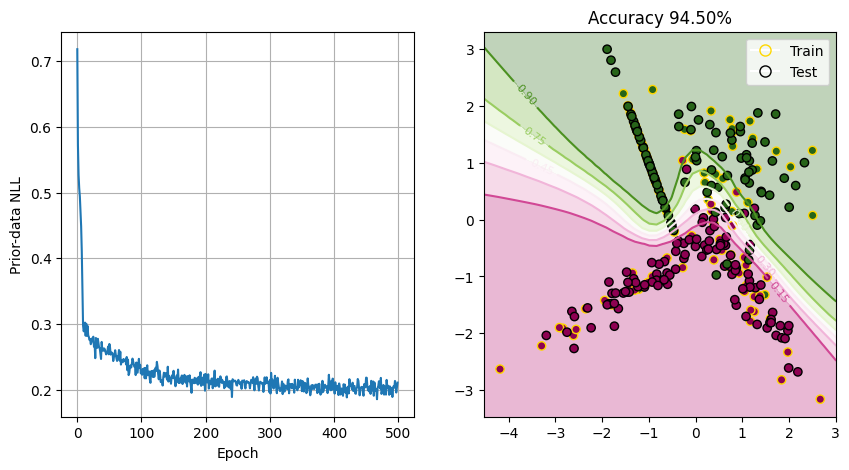

Epoch   500 | Loss 0.211: 100%|██████████| 500/500 [03:36<00:00,  2.30it/s]


In [6]:
from tqdm import trange
from IPython.display import clear_output, display
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification, make_blobs

# NOTE: If you don't have access to a GPU or you're having difficulties to train
# the model in a reasonble amount of time, change the prior to a simpler one
# like `make_blobs()` with `centers=2` (for binary classification) and lower the
# number of epochs to ~200.

# --- Define prior distribution over binary classification tasks ---
# sample_from_prior = lambda n_samples: make_blobs(n_samples, centers=2)
sample_from_prior = lambda n_samples: make_classification(n_samples, n_features=2, n_redundant=0)

# --- Define training parameters ---
batch_size = 256
num_epochs = 500

train_size = 100  # No. data points used for training
query_size = 50  # No. data points used for testing (size of the hold-out set)
n_samples = train_size + query_size  # No. data points to sample for a given clasif. task

# --- Define model ---
pfn = BernoulliPFN(
    num_features=2,
    dim_model=256,
    dim_feedforward=512,
    num_heads=8,
    num_decoder_layers=2,
    num_encoder_layers=2,
).to(device)

# --- Define optimizer ---
optimizer = torch.optim.AdamW(pfn.parameters(), lr=3e-4)

# --- Prepare fixed data on which we will monitor the PPD approximated by PFN ---
X_fixed, y_fixed = sample_from_prior(n_samples=300)

X_fixed = torch.from_numpy(X_fixed).float().to(device)
y_fixed = torch.from_numpy(y_fixed).float().unsqueeze(-1).to(device)

X_train_fixed = X_fixed[:train_size, :]
X_query_fixed = X_fixed[train_size:, :]
y_train_fixed = y_fixed[:train_size, :]
y_query_fixed = y_fixed[train_size:, :]

fixed_data = (X_train_fixed, X_query_fixed, y_train_fixed, y_query_fixed)

# ---
loss_hist: list[float] = []

# NOTE: This flag controls whether to plot live animation during training
# WARN: You may experience some flickering when using Google Colab env
visualize: bool = True
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))


# ################################################
# ##########     Training Loop     ###############
# ################################################

for epoch in (pbar := trange(num_epochs)):
    pfn.train()

    # --- Sample batch of classification tasks from the prior ---
    data = [sample_from_prior(n_samples) for _ in range(batch_size)]

    X, y = zip(*data)
    X, y = np.stack(X), np.stack(y)
    X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float().unsqueeze(-1)
    X, y = X.to(device), y.to(device)

    X_train, y_train = X[:, :train_size, :], y[:, :train_size, :]
    X_query, y_query = X[:, train_size:, :], y[:, train_size:, :]

    # --- Train model ---
    logits = pfn(X_train, y_train, X_query)
    loss = F.binary_cross_entropy_with_logits(logits, y_query)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # --- Log progress ---
    loss_hist.append(loss.item())
    pbar.set_description(f"Epoch {epoch+1:>5d} | Loss {loss.item():.3f}")

    # --- Visualize the PPD approximated by PFN on a fixed dataset ---
    acc = accuracy_score(
        y_true=y_query_fixed.cpu().numpy(),
        y_pred=pfn.predict(X_train_fixed, y_train_fixed, X_query_fixed).cpu().numpy(),
    )

    if visualize:
        clear_output(wait=True)
        ax[0].clear()
        ax[1].clear()
        ax[1].set_title(f"Accuracy {acc:.2%}")
        plot_loss_hist(ax[0], loss_hist, ylabel="Prior-data NLL")
        plot_pfn_decision_boundary(ax[1], pfn, *fixed_data, device)
        display(fig)
        plt.close(fig)

#### Zadanie 3.

Na zakończenie sprawdzimy jak wytrenowany model radzi sobie na różnych
datasetach spróbkowanych z priora i porównamy go z siecią neuronową wytrenowaną
bezpośrednio na danym zbiorze. Dodatkowo przyjrzymy się różnicom w granicach
decyzyjnych obu modeli. Zauważ, że dla nowych datasetów sieć PFN wykonuje tylko
jedną propagację w przód, aby wyznaczyć predykcje, natomiast klasyczna sieć musi
być wytrenowana osobno na każdym spróbkowanym zbiorze.

> **Zadanie:** Poniższe dwie komórki zawierają kod, który losuje ze
> zdefiniowanego wcześniej priora zbiór danych, dokonuje jego podziału na zbiór
> treningowy i testowy, po czym wyznacza dokładność na zbiorze testowym i rysuje
> granice decyzyjne dla wytrenowanej sieci PFN i modelu `MLPClassifier` z
> biblioteki Scikit-learn. Wykonaj poniższe komórki kilka razy i zaobserwuj
> wyniki. Co możesz powiedzieć o granicach decyzyjnych obu modeli? Który model
> wg. Ciebie lepiej generalizuje? Opcjonalnie możesz powtórzyć eksperyment na
> innym zbiorze danych (klasyfikacji binarnej z dwoma predyktorami), który nie
> pochodzi z priora, na którym trenowaliśmy sieć PFN. Jak teraz wyglądają
> wyniki?

Accuracy 91.00%


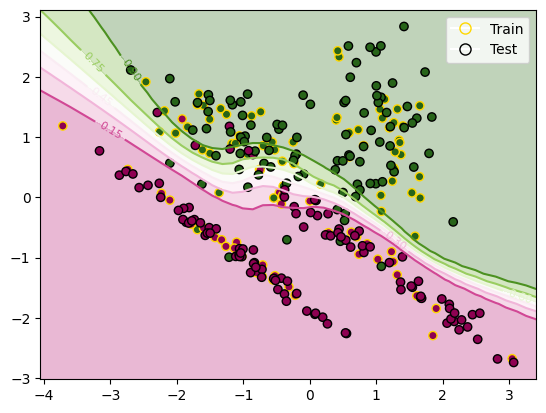

In [12]:
from sklearn.model_selection import train_test_split

data_X, data_y = sample_from_prior(n_samples=300)
X_train, X_query, y_train, y_query = train_test_split(data_X, data_y, train_size=train_size)

X_train = torch.from_numpy(X_train).float().to(device)
X_query = torch.from_numpy(X_query).float().to(device)
y_train = torch.from_numpy(y_train).unsqueeze(-1).float().to(device)
y_query = torch.from_numpy(y_query).unsqueeze(-1).float().to(device)

acc = accuracy_score(
    y_true=y_query.cpu().numpy(),
    y_pred=pfn.predict(X_train, y_train, X_query).cpu().numpy(),
)
print(f"Accuracy {acc:.2%}")

_, ax = plt.subplots()
plot_pfn_decision_boundary(ax, pfn, X_train, X_query, y_train, y_query, device)

Accuracy 92.50%


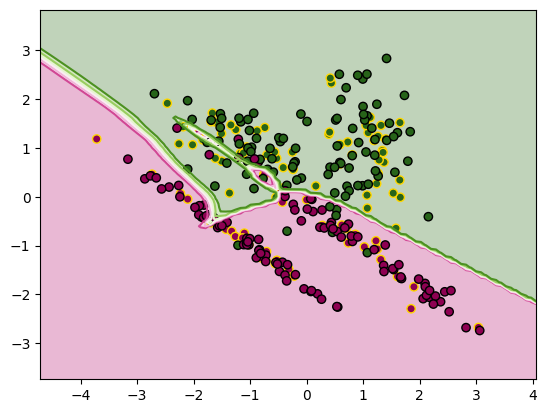

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neural_network import MLPClassifier


clf = MLPClassifier(
    hidden_layer_sizes=[512, 512, 512],
    learning_rate_init=3e-4,
    max_iter=1_000,
)
clf.fit(X_train.cpu().numpy(), y_train.cpu().numpy().squeeze())

acc = accuracy_score(
    y_true=y_query.cpu().numpy().squeeze(),
    y_pred=clf.predict(X_query.cpu().numpy()),
)
print(f"Accuracy {acc:.2%}")

_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf,
    data_X,
    cmap="PiYG",
    plot_method="contour",
    vmin=0.0,
    vmax=1.0,
    ax=ax,
)
DecisionBoundaryDisplay.from_estimator(
    clf,
    data_X,
    cmap="PiYG",
    plot_method="contourf",
    vmin=0.0,
    vmax=1.0,
    alpha=0.3,
    ax=ax,
)
ax.scatter(
    X_train.cpu().numpy()[:, 0],
    X_train.cpu().numpy()[:, 1],
    c=y_train.cpu().numpy().squeeze(),
    edgecolors="gold",
    cmap="PiYG",
)
ax.scatter(
    X_query.cpu().numpy()[:, 0],
    X_query.cpu().numpy()[:, 1],
    c=y_query.cpu().numpy().squeeze(),
    edgecolors="k",
    cmap="PiYG",
)
plt.show()